In [270]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [6]:
# !pip install gensim
# !pip install spacy

In [3]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/u6066091/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [7]:
df = pd.read_csv('/Users/u6066091/Desktop/kaggle/output/corona_challenge/biorxiv.csv')
# data = df.text_body.values.tolist()
# we have to do topic modeling per sentence
data = df.title.values.tolist()
# for text in df['title']:
#     sentence = text.split('/n')
#     data.extend(sentence)

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# print(data_words[:1])

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
# !python -m spacy download en

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# took forever
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python -m spacy download en

nlp = spacy.load('en', disable=['parser', 'ner'])

# # Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# # ValueError: [E088] Text of length 1500313 exceeds maximum of 1000000. 
# # The v2.x parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input.
# # This means long texts may cause memory allocation errors. If you're not using the parser or NER, it's probably safe to increase the `nlp.max_length` limit. 
# # The limit is in number of characters, so you can check whether your inputs are too long by checking `len(text)`.

# print(data_lemmatized[:1])

In [65]:
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# data_lemmatized = data_words_bigrams
# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View


In [1]:
###### Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

NameError: name 'gensim' is not defined

In [14]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(38,
  '0.000*"eicosanoid" + 0.000*"pseudokinase" + 0.000*"deplete" + '
  '0.000*"capillary_electrophoresis" + 0.000*"humane" + 0.000*"qe" + '
  '0.000*"cress" + 0.000*"disinfecting" + 0.000*"rectal" + 0.000*"dimeric"'),
 (41,
  '0.000*"eicosanoid" + 0.000*"pseudokinase" + 0.000*"deplete" + '
  '0.000*"capillary_electrophoresis" + 0.000*"humane" + 0.000*"qe" + '
  '0.000*"cress" + 0.000*"disinfecting" + 0.000*"rectal" + 0.000*"dimeric"'),
 (37,
  '0.000*"eicosanoid" + 0.000*"pseudokinase" + 0.000*"deplete" + '
  '0.000*"capillary_electrophoresis" + 0.000*"humane" + 0.000*"qe" + '
  '0.000*"cress" + 0.000*"disinfecting" + 0.000*"rectal" + 0.000*"dimeric"'),
 (25,
  '0.000*"eicosanoid" + 0.000*"pseudokinase" + 0.000*"deplete" + '
  '0.000*"capillary_electrophoresis" + 0.000*"humane" + 0.000*"qe" + '
  '0.000*"cress" + 0.000*"disinfecting" + 0.000*"rectal" + 0.000*"dimeric"'),
 (2,
  '0.000*"eicosanoid" + 0.000*"pseudokinase" + 0.000*"deplete" + '
  '0.000*"capillary_electrophoresis" + 0

In [17]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -39.338065611040406

Coherence Score:  0.5899726444138375


In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

TypeError: Object of type complex is not JSON serializable

PreparedData(topic_coordinates=                        x                   y  topics  cluster       Freq
topic                                                                    
48    -0.261399+0.000000j  0.460058+0.000000j       1        1  12.861009
11    -0.229836+0.000000j -0.068870+0.000000j       2        1   7.131336
46    -0.230404+0.000000j -0.062366+0.000000j       3        1   6.938358
12    -0.216453+0.000000j -0.054983+0.000000j       4        1   6.141450
6     -0.210397+0.000000j -0.046143+0.000000j       5        1   5.073223
49    -0.176164+0.000000j -0.027987+0.000000j       6        1   4.278067
9     -0.173254+0.000000j -0.027065+0.000000j       7        1   4.264076
24    -0.173414+0.000000j -0.029403+0.000000j       8        1   4.145451
20    -0.186762+0.000000j -0.034642+0.000000j       9        1   3.991848
3     -0.167608+0.000000j -0.026577+0.000000j      10        1   3.756621
42    -0.177090+0.000000j -0.031868+0.000000j      11        1   3.573816
40    -

In [89]:
mallet_path = '/Users/u6066091/Desktop/kaggle/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
# Show Topics
pprint(ldamallet.show_topics(formatted=False)

[(18,
  [('outbreak', 0.05582097058083983),
   ('epidemic', 0.043248679909479504),
   ('impact', 0.03143072667840081),
   ('dynamic', 0.030173497611264772),
   ('spread', 0.02539602715614785),
   ('syndrome', 0.02388735227558461),
   ('pattern', 0.023133014835302994),
   ('pandemic', 0.02263012320844858),
   ('contact', 0.019612773447322103),
   ('management', 0.018606990193613275)]),
 (16,
  [('host', 0.08140422284406004),
   ('antiviral', 0.06792164843551259),
   ('target', 0.06715848384634952),
   ('potential', 0.05113202747392521),
   ('approach', 0.03790384126176546),
   ('interaction', 0.03154413635207327),
   ('identify', 0.03103535995929789),
   ('drug', 0.03001780717374714),
   ('peptide', 0.029254642584584076),
   ('therapeutic', 0.0287458661918087)]),
 (9,
  [('virus', 0.38944723618090454),
   ('diarrhea', 0.053266331658291456),
   ('strain', 0.04773869346733668),
   ('isolate', 0.027889447236180906),
   ('pig', 0.02512562814070352),
   ('variant', 0.021859296482412062),
   

In [90]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.3465776287677863


In [92]:
# Topic optimization
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [97]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=4, limit=40, step=4)

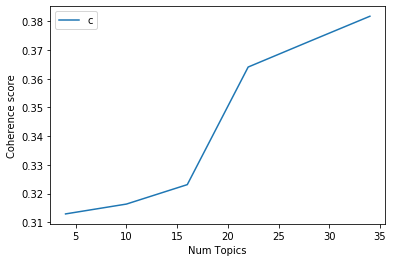

In [99]:
# Show graph
limit=40; start=4; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [103]:
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(9,
  '0.215*"protein" + 0.098*"receptor" + 0.066*"bind" + 0.057*"domain" + '
  '0.042*"structural" + 0.033*"fusion" + 0.031*"epitope" + 0.028*"peptide" + '
  '0.023*"spike" + 0.022*"site"'),
 (20,
  '0.156*"analysis" + 0.113*"sequence" + 0.085*"reveal" + 0.044*"genome" + '
  '0.042*"pattern" + 0.037*"genomic" + 0.020*"diversity" + 0.019*"proteomic" + '
  '0.018*"variation" + 0.015*"cluster"'),
 (29,
  '0.091*"outbreak" + 0.074*"epidemic" + 0.045*"early" + 0.038*"model" + '
  '0.033*"contact" + 0.029*"title" + 0.024*"animal" + 0.024*"time" + '
  '0.021*"measure" + 0.020*"chinese"'),
 (32,
  '0.295*"virus" + 0.097*"infect" + 0.033*"fever" + 0.033*"derive" + '
  '0.032*"protect" + 0.032*"mouse" + 0.028*"hepatitis" + 0.021*"screening" + '
  '0.018*"resistant" + 0.018*"experimental"'),
 (7,
  '0.164*"detection" + 0.064*"method" + 0.050*"rapid" + 0.044*"sample" + '
  '0.037*"feline" + 0.036*"detect" + 0.031*"assay" + 0.031*"comparison" + '
  '0.025*"cat" + 0.018*"diagnostic"'),
 (12,
  '0.

In [104]:
# Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,28.0,0.0487,"virus, diarrhea, strain, isolate, pig, variant...",Complete Genome Sequence of Bordetella bronchi...
1,1,0.0,0.0294,"infection, viral, level, increase, reduce, low...",NaN
2,2,1.0,0.0946,"response, immune, induce, mouse, enhance, immu...",Two novel HLA-A*0201 T-cell epitopes in avian ...
3,3,1.0,0.0591,"response, immune, induce, mouse, enhance, immu...",Protective Effects of Long Pentraxin PTX3 on L...
4,4,29.0,0.0671,"outbreak, epidemic, early, model, contact, tit...",Veterinary Science Short Communication Prevale...
5,5,0.0,0.0294,"infection, viral, level, increase, reduce, low...",NaN
6,6,4.0,0.0643,"influenza, bat, virus, avian, coronaviruse, ch...",Detection of Group 1 Coronaviruses in Bats in ...
7,7,0.0,0.0294,"infection, viral, level, increase, reduce, low...",NaN
8,8,6.0,0.0429,"viral, role, pathogen, bacterial, multiple, pa...",Common Commercial Cosmetic Products Induce Art...
9,9,14.0,0.0778,"human, antibody, tissue, bovine, blood, calf, ...",Human Metapneumovirus and Other Respiratory Vi...


In [105]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3457,"infection, viral, level, increase, reduce, low...",impaired production of immune mediators in den...
1,1.0,0.1614,"response, immune, induce, mouse, enhance, immu...",Specific Plasma Autoantibody Reactivity in Mye...
2,2.0,0.2140,"base, model, approach, surveillance, datum, ev...",Steps to a Sustainable Public Health Surveilla...
3,3.0,0.1616,"antiviral, target, activity, potential, drug, ...",HIV-1 Frameshift RNA-Targeted Compounds Incorp...
4,4.0,0.1703,"influenza, bat, virus, avian, coronaviruse, ch...",Antivirals for influenza-like illness? Protoco...


In [14]:
import json
import pandas as pd

In [223]:
# cd '/Users/u6066091/Desktop/kaggle/output/corona_challenge/curated/keshav'
!ls

data_file.json            risk_smoke_summary_v1.csv summary_abst.json
extractive_summaries.csv  smoke_sel.csv
risk_covid_summary.csv    sth.json


In [239]:
data = pd.read_csv('extractive_summaries.csv')
data.columns

Index(['Unnamed: 0', 'doc_id', 'title', 'abstract', 'scibert_summary'], dtype='object')

In [240]:
with open('ext_sum.json', 'w') as fout:
    all_data = []
    for i in range(0,data.shape[0]):
        json_data = {'tgt':data.loc[i,'abstract'], 'src':data.loc[i,'scibert_summary']}
        all_data.append(json.dumps(json_data, ensure_ascii=False))
    fout.write("\n".join(all_data))

In [135]:
import json
with open('outputfile.json', 'w') as fout:
    json.dump(results, fout, ensure_ascii=False)

In [207]:
pwd

'/Users/u6066091/Desktop/kaggle/output/corona_challenge/curated/keshav'

In [241]:
ls

data_file.json             risk_smoke_summary_v1.csv
ext_sum.json               smoke_sel.csv
extractive_summaries.csv   sth.json
risk_covid_summary.csv     summary_abst.json


In [255]:
d1 = pd.read_csv('risk_covid_summary.csv')

In [246]:
ls_rk = d1['doc_id']

In [247]:
d2 = pd.read_csv('extractive_summaries.csv')

In [ ]:
d3.head()

In [248]:
ls_ext_sum = d2['doc_id']

In [266]:
summ = []
import re
for doi in d1['doc_id']:
    if doi not in d2['doc_id']:
        summ.append(doi)
d3 = d1[d1['doc_id'].isin(summ)]  
d3.head()

,Unnamed: 0,Unnamed: 0.1,doc_id,source,title,abstract,text_body,index,count_risk,sha,...,Total Cites (3years),Citable Docs. (3years),Cites / Doc. (2years),Ref. / Doc.,Country,Publisher,Coverage,Categories,rank,summary
0,0,0,f47af9fe364fd9bac5e061142208d801667c5aca,COMMON_USE_SUB,How to differentiate COVID-19 pneumonia from h...,OBJECTIVES To compare chest CT findings in hea...,"In December 2019, an outbreak of Corona Virus ...",NaN,0.000000,NaN,...,4434,1145,"4,16","29,10",United States,Lippincott Williams & Wilkins Ltd.,1963-ongoing,Transplantation (Q1),2.588869,"In December 2019, an outbreak of Corona Virus ..."
1,1,1,46bf124930f3ef18bc9dd2d4ae356a45d3bae461,COMMON_USE_SUB,Chest Radiographic and CT Findings of the 2019...,Objective: This study presents a preliminary r...,https://doi.org/10.3348/kjr.2020.0132 kjronlin...,NaN,0.000000,NaN,...,2077,347,"5,41","68,42",United Kingdom,Elsevier Ltd.,1982-ongoing,"Strategy and Management (Q1); Tourism, Leisure...",2.063335,https://doi.org/10.3348/kjr.2020.0132 kjronlin...
2,2,2,e9457327ddb51cf3ceb3698660ff08f526a09d44,COMMON_USE_SUB,Analysis of factors associated with disease ou...,"Background: Since early December 2019, the 201...","Since December 2019, unexplained pneumonia has...",2102.0,0.000552,NaN,...,3608,275,"14,56","44,37",United Kingdom,Nature Publishing Group,2009-ongoing,"Endocrinology (Q1); Endocrinology, Diabetes an...",1.871994,"Since December 2019, unexplained pneumonia has..."
3,3,3,3c94f582610453b6c1389c3a5d6ad57bcf0ba033,COMMON_USE_SUB,Clinical characteristics of 25 death cases wit...,confirmed and 1368 patients have died from the...,The pneumonia caused by the 2019 novel coronav...,NaN,0.000000,NaN,...,3225,608,"4,96","51,39",United States,Elsevier Inc.,1970-ongoing,Cardiology and Cardiovascular Medicine (Q1); M...,1.361633,The pneumonia caused by the 2019 novel coronav...
4,4,4,875b7c463f00772fa0dc18ada678bc1ff16a4274,COMMON_USE_SUB,performed data analysis,Objective: To evaluate the spectrum of comorbi...,"-Since November 2019, the rapid outbreak of co...",NaN,0.000881,NaN,...,473,17,"11,58","54,29",United States,Lawrence Erlbaum Associates Inc.,"1990-1996, 1998-ongoing",Psychology (miscellaneous) (Q1),1.354095,"-Since November 2019, the rapid outbreak of co..."


In [269]:
d3 = d1[d1['doc_id'].isin(summ)]
with open('ext_sum_valid.json', 'w') as fout:
    all_data = []
    for i in range(0,d3.shape[0]):
        json_data = {'tgt': "alaki", 'src':d3.loc[i,'summary']}
        all_data.append(json.dumps(json_data, ensure_ascii=False))
    fout.write("\n".join(all_data))

In [264]:
pwd

'/Users/u6066091/Desktop/kaggle/output/corona_challenge/curated/keshav'